In [2]:
%matplotlib inline
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')
plt.style.use('ggplot')
import statsmodels.formula.api as smf
from nipype.interfaces.afni.preprocess import TCorr1D

In [ ]:
# the melodic output giving each ICA timeseries
ica_ts = pd.read_csv('./data/test_bold_MELODICmix.tsv', sep='\t', header=None)
ica_ts.dropna(axis='columns', how='all', inplace=True)
ica_ts = ica_ts.add_prefix('comp_')
ica_ts.head()


In [ ]:
# load the noise indices
ica_noise_idx = np.loadtxt('./data/test_bold_AROMAnoiseICs.csv', delimiter=',', dtype='int')
ica_noise_idx -= 1
ica_noise_idx

In [ ]:
signal_noise_idx = np.full(len(ica_ts.columns), 'signal')
signal_noise_idx[ica_noise_idx] = 'noise'
signal_noise_idx


In [ ]:
color_idx = np.array([st.replace('noise', 'red').replace('signal', 'green') for st in signal_noise_idx])
color_idx

In [ ]:
# the confounds tsv
confounds = pd.read_csv('./data/test_bold_confounds.tsv', sep='\t')
confounds['FramewiseDisplacement'][0] = confounds['FramewiseDisplacement'][1:].mean()
confounds.head()

In [ ]:
correlations = np.corrcoef(ica_ts, rowvar=False)

In [ ]:
# make the figure bigger overall
plt.rcParams["figure.figsize"] = (20,20)
fig = sns.heatmap(correlations, 
                  yticklabels=signal_noise_idx, #label the yaxis with individual markers
                  vmin=-1, vmax=1, # set the colorbar to go from -1 to 1
                  cmap="RdBu") # have the color gradient go from red to blue
for color,tick in zip(color_idx, fig.yaxis.get_major_ticks()):
    tick.label1.set_color(color) # set the individual colors
    tick.label1.set_fontsize('15') # increase the size
fig.set_ylabel('Classification (Signal or Noise)', fontdict={'fontsize': 25})
fig.set_xlabel('ICA Component Number', fontdict={'fontsize': 25})
fig.set_title('Correlation of ICA Components', fontdict={'fontsize': 30})

In [ ]:
# get a voxel in the right insula
bold_img = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
bold_data = bold_img.get_data()
right_insula = bold_data[37,44,19]
right_insula_df = pd.DataFrame.from_dict({'right_insula': right_insula})

In [ ]:
# Component 47 (e.g. indexed 46) looks like fronto-parietal network
# ica_ts[46]
aroma_confounds = confounds.filter(regex='AROMA.*')
aroma_confounds.insert(0, 'right_insula', right_insula)
aroma_confounds.head()

In [ ]:
# get the frequency spectra of the signal component
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(aroma_confounds['right_insula'])
plt.title('right insula voxel')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [ ]:
# statsmodels (aggressive denoising)
column_names = aroma_confounds.columns.tolist()
column_names.remove('right_insula')
all_columns = "+".join(column_names)

model_agg = smf.ols('right_insula ~ ' + all_columns, data=aroma_confounds)

In [ ]:
fit_agg = model_agg.fit()

In [ ]:
plt.plot(fit_agg.resid)
plt.title('fronto-parietal component (cleaned)')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [ ]:
fit_agg.summary()

In [ ]:
# non-aggressive
all_comps = '+'.join([str(x) for x in ica_ts.columns.tolist()])
model_noise = smf.ols('right_insula ~ ' + all_comps, data=pd.concat([ica_ts, right_insula_df], axis='columns'))
fit_noise = model_noise.fit()
noise_series = np.dot(ica_ts.iloc[:,ica_noise_idx], fit_noise.params[ica_noise_idx])
right_insula_nonaggr = right_insula_df['right_insula'] - noise_series

In [ ]:
# write three text files for analysis
fit_agg.resid.to_csv('./data/right_insula-aggr.txt', index=False)
right_insula_df.to_csv('./data/right_insula-orig.txt', index=False, header=False)
right_insula_nonaggr.to_csv('./data/right_insula-nonaggr.txt', index=False)

In [ ]:

afni_corr_objs = {}
for signal in ['orig', 'aggr', 'nonaggr']:
    afni_corr = TCorr1D(xset='./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                        y_1d='./data/right_insula-{sig}.txt'.format(sig=signal),
                        args='-mask ./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
                        out_file='./data/right_insula-{sig}_corr.nii.gz'.format(sig=signal))
    res = afni_corr.run()
    afni_corr_objs[signal] = res.outputs.out_file


In [ ]:
from nilearn.plotting import plot_stat_map
for signal, stat in afni_corr_objs.items():
    print(signal)
    plot_stat_map(stat, threshold=0.3, cut_coords=[31,19,-2], vmax=1.0)


In [ ]:
motion_params = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
names = ['aggressive', 'original', 'nonaggressive']

sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['FramewiseDisplacement'].T), 
            yticklabels=names + ['FramewiseDisplacement'], # label the yaxis with individual markers
            xticklabels=names + ['FramewiseDisplacement'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap="GnBu")

In [ ]:
sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['GlobalSignal'].T), 
            yticklabels=names + ['GlobalSignal'], # label the yaxis with individual markers
            xticklabels=names + ['GlobalSignal'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap="GnBu")

# Modular Preprocessing

In [ ]:
sns.heatmap(np.corrcoef(pd.concat([right_insula_df, confounds.GlobalSignal, confounds.FramewiseDisplacement], axis='columns'), rowvar=False))

In [ ]:
pd.concat([right_insula_df, confounds.GlobalSignal, confounds.FramewiseDisplacement], axis='columns')

In [ ]:
sns.lineplot(data=pd.concat([confounds.GlobalSignal + right_insula.mean(), right_insula_df], axis='columns'))

In [ ]:
# bold_image = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
# mask_image = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

In [ ]:
# bold_data = bold_image.get_data()
# bold_data_2d = bold_data.reshape(np.prod(bold_data.shape[:-1]), bold_data.shape[-1])

In [ ]:
# mask_data = mask_image.get_data()
# mask_data = mask_data.astype(bool)


In [ ]:
# bold_data_masked = bold_data[mask_data]
# bold_data_masked.shape

In [ ]:
from nilearn.connectome import ConnectivityMeasure
connectivity_measure = ConnectivityMeasure(kind='correlation')


## Dummy ICA example

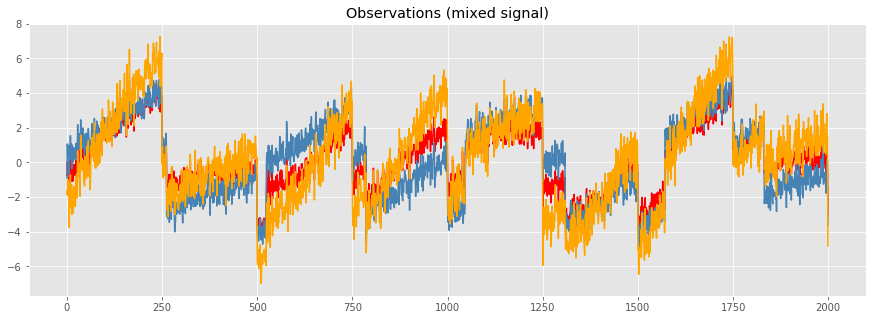

In [19]:
from scipy import signal

from sklearn.decomposition import FastICA, PCA
plt.rcParams["figure.figsize"] = (15,5)
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

plt.title(names[0])
for sig, color in zip(models[0].T, colors):
    plt.plot(sig, color=color)
plt.savefig('./imgs/observations.png')

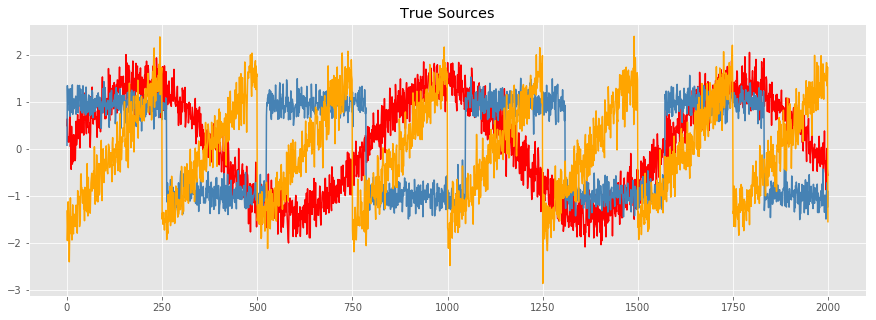

In [20]:
plt.figure()
plt.title(names[1])
for sig, color in zip(models[1].T, colors):
    plt.plot(sig, color=color)
plt.savefig('./imgs/true_sources.png')

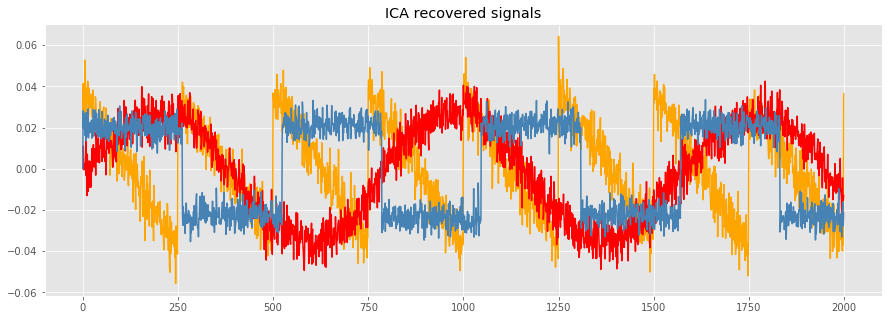

In [21]:
plt.figure()
plt.title(names[2])
for sig, color in zip(models[2].T, [colors[2], colors[0], colors[1]]):
    plt.plot(sig, color=color)
plt.savefig('./imgs/ica_recovered_signals.png')

In [7]:
colors[::-1]

['orange', 'steelblue', 'red']

In [ ]:
models[2].shape

In [ ]:
models[1]